## Batch + Epoch

## Pytorch Network Training

### Input

1. realizations of Independent variable 
2. Initial values of all weights 
3. Build a Network 

    __def__ __ init __: torch.nn.Module $\leftarrow$ super & Set All Parameters of Network
    
    __def__ forward: Build a Network using __  init  __ 

4. realizations of Dependent variable   
5. Loss function (torch.nn.MSELoss)
6. Otimization (torch.optim.SGD)


### Output

1. Updated all weights 

### Process
For $i$ = 1:  
1. Calculate Forward values using Initial values(2), Forward function(3) and Independent variable realization(1) 
2. Calculate Loss values using Forward values, Loss function(5) and Dependent variable realization(4) 
3. Calculate Gradient using (5) and (6)

    - optimizer.zero_grad() # initialize gradient
    
    - loss.backward() # calculate gradient

4. Update all weights
  
    - optimizer.step() # update weight


In [19]:
import random
import torch

In [20]:

class DynamicNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        생성자에서 순전파 단계에서 사용할 3개의 nn.Linear 인스턴스를 생성합니다.
        """
        super(DynamicNet, self).__init__()
        self.input_linear = torch.nn.Linear(D_in, H)
        self.middle_linear = torch.nn.Linear(H, H)
        self.output_linear = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        모델의 순전파 단계에서, 무작위로 0, 1, 2 또는 3 중에 하나를 선택하고
        은닉층을 계산하기 위해 여러번 사용한 middle_linear Module을 재사용합니다.

        각 순전파 단계는 동적 연산 그래프를 구성하기 때문에, 모델의 순전파 단계를
        정의할 때 반복문이나 조건문과 같은 일반적인 Python 제어 흐름 연산자를 사용할
        수 있습니다.

        여기에서 연산 그래프를 정의할 때 동일 Module을 여러번 재사용하는 것이
        완벽히 안전하다는 것을 알 수 있습니다. 이것이 각 Module을 한 번씩만 사용할
        수 있었던 Lua Torch보다 크게 개선된 부분입니다.
        """
        h_relu = self.input_linear(x).clamp(min=0)
        for _ in range(random.randint(0, 3)):
            h_relu = self.middle_linear(h_relu).clamp(min=0)
        y_pred = self.output_linear(h_relu)
        return y_pred


# N은 배치 크기이며, D_in은 입력의 차원입니다;
# H는 은닉층의 차원이며, D_out은 출력 차원입니다.
N, D_in, H, D_out = 64, 1000, 100, 10

# 입력과 출력을 저장하기 위해 무작위 값을 갖는 Tensor를 생성합니다.
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# 앞서 정의한 클래스를 생성(instantiating)하여 모델을 구성합니다.
model = DynamicNet(D_in, H, D_out)

# 손실함수와 Optimizer를 만듭니다. 이 이상한 모델을 순수한 확률적 경사 하강법
# (stochastic gradient decent)으로 학습하는 것은 어려우므로, 모멘텀(momentum)을
# 사용합니다.
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)


lr = 0.5
epochs = 200
bs = 64
for t in range(epochs):
    for i in range((N-1)//bs+1):
        start_i = i * bs
        end_i = start_i + bs

        xb = x[start_i:end_i]
        yb = y[start_i:end_i]

        # 순전파 단계: 모델에 x를 전달하여 예상되는 y 값을 계산합니다.
        y_pred = model(xb)

        # 손실을 계산하고 출력합니다.
        loss = criterion(y_pred, yb)
        if t % 100 == 99:
            print(t, loss.item())

        # 변화도를 0으로 만들고, 역전파 단계를 수행하고, 가중치를 갱신합니다.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

99 8.998567581176758
199 4.566229820251465


train_ds[i\*bs : i\*bs+bs] $\Leftrightarrow$ 
xb = x_train[i\*bs : i\*bs+bs]
yb = y_train[i\*bs : i\*bs+bs]

In [29]:
train_ds = TensorDataset(x, y) # x_train: tensor, y_train: tensor 를 묶어줌

In [30]:
xb,yb = train_ds[i*bs : i*bs+bs]
print(xb)
print(yb)

tensor([[ 0.8454, -0.2373, -0.4263,  ...,  0.4333, -1.9265,  0.6532],
        [-1.3056,  0.4394, -0.5685,  ...,  1.1379, -0.7145,  1.0281],
        [-0.4917, -0.5335, -0.6073,  ..., -0.1145,  0.4306, -0.6809],
        ...,
        [-1.1678,  1.6345, -1.4038,  ...,  1.6475,  0.5500, -0.4286],
        [-0.3699, -0.5681, -0.5442,  ..., -0.0109,  0.5118, -0.8183],
        [-0.6643,  1.0410, -1.0521,  ...,  0.5783,  0.3589, -0.8500]])
tensor([[ 2.0702,  0.3175,  0.5515, -1.3652,  0.7640, -1.9492, -0.9827,  0.0210,
          2.0341,  0.6899],
        [ 0.4144, -0.6626, -1.2219,  1.3009, -0.7227,  0.6045, -0.7100,  0.2721,
          1.5357,  0.6288],
        [-0.2894, -1.4868,  1.5710,  0.3175, -1.2980,  3.0277,  1.9245,  1.3926,
         -0.1419,  0.8305],
        [-0.1430, -0.4951,  1.9091,  1.4889,  0.6624,  2.4976, -0.0045,  2.2970,
         -0.6519, -1.1069],
        [-1.2167,  0.6220, -0.5087,  0.5175,  0.0148,  0.7492, -1.5500, -0.8299,
          1.5975, -0.4718],
        [ 0.0868,  0.

In [32]:
xb = x[i*bs : i*bs+bs]
yb = y[i*bs : i*bs+bs]
print(xb)
print(yb)

tensor([[ 0.8454, -0.2373, -0.4263,  ...,  0.4333, -1.9265,  0.6532],
        [-1.3056,  0.4394, -0.5685,  ...,  1.1379, -0.7145,  1.0281],
        [-0.4917, -0.5335, -0.6073,  ..., -0.1145,  0.4306, -0.6809],
        ...,
        [-1.1678,  1.6345, -1.4038,  ...,  1.6475,  0.5500, -0.4286],
        [-0.3699, -0.5681, -0.5442,  ..., -0.0109,  0.5118, -0.8183],
        [-0.6643,  1.0410, -1.0521,  ...,  0.5783,  0.3589, -0.8500]])
tensor([[ 2.0702,  0.3175,  0.5515, -1.3652,  0.7640, -1.9492, -0.9827,  0.0210,
          2.0341,  0.6899],
        [ 0.4144, -0.6626, -1.2219,  1.3009, -0.7227,  0.6045, -0.7100,  0.2721,
          1.5357,  0.6288],
        [-0.2894, -1.4868,  1.5710,  0.3175, -1.2980,  3.0277,  1.9245,  1.3926,
         -0.1419,  0.8305],
        [-0.1430, -0.4951,  1.9091,  1.4889,  0.6624,  2.4976, -0.0045,  2.2970,
         -0.6519, -1.1069],
        [-1.2167,  0.6220, -0.5087,  0.5175,  0.0148,  0.7492, -1.5500, -0.8299,
          1.5975, -0.4718],
        [ 0.0868,  0.

train_ds[i\*bs : i\*bs+bs] $\Leftrightarrow$ 
xb = x_train[i\*bs : i\*bs+bs]
yb = y_train[i\*bs : i\*bs+bs] $\Leftrightarrow$ DataLoader(train_ds, batch_size=bs)

In [33]:
from torch.utils.data import TensorDataset

In [34]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x, y)
train_dl = DataLoader(train_ds, batch_size=bs)

In [36]:
for i in range((N-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    pred = model(xb)

In [37]:
for xb,yb in train_dl:
    pred = model(xb)

In [38]:
class DynamicNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        생성자에서 순전파 단계에서 사용할 3개의 nn.Linear 인스턴스를 생성합니다.
        """
        super(DynamicNet, self).__init__()
        self.input_linear = torch.nn.Linear(D_in, H)
        self.middle_linear = torch.nn.Linear(H, H)
        self.output_linear = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        모델의 순전파 단계에서, 무작위로 0, 1, 2 또는 3 중에 하나를 선택하고
        은닉층을 계산하기 위해 여러번 사용한 middle_linear Module을 재사용합니다.

        각 순전파 단계는 동적 연산 그래프를 구성하기 때문에, 모델의 순전파 단계를
        정의할 때 반복문이나 조건문과 같은 일반적인 Python 제어 흐름 연산자를 사용할
        수 있습니다.

        여기에서 연산 그래프를 정의할 때 동일 Module을 여러번 재사용하는 것이
        완벽히 안전하다는 것을 알 수 있습니다. 이것이 각 Module을 한 번씩만 사용할
        수 있었던 Lua Torch보다 크게 개선된 부분입니다.
        """
        h_relu = self.input_linear(x).clamp(min=0)
        for _ in range(random.randint(0, 3)):
            h_relu = self.middle_linear(h_relu).clamp(min=0)
        y_pred = self.output_linear(h_relu)
        return y_pred


# N은 배치 크기이며, D_in은 입력의 차원입니다;
# H는 은닉층의 차원이며, D_out은 출력 차원입니다.
N, D_in, H, D_out = 64, 1000, 100, 10

# 입력과 출력을 저장하기 위해 무작위 값을 갖는 Tensor를 생성합니다.
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# 앞서 정의한 클래스를 생성(instantiating)하여 모델을 구성합니다.
model = DynamicNet(D_in, H, D_out)

# 손실함수와 Optimizer를 만듭니다. 이 이상한 모델을 순수한 확률적 경사 하강법
# (stochastic gradient decent)으로 학습하는 것은 어려우므로, 모멘텀(momentum)을
# 사용합니다.
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)


lr = 0.5
epochs = 200
bs = 64
for t in range(epochs):
    for i in range((N-1)//bs+1):
        start_i = i * bs
        end_i = start_i + bs

        xb = x[start_i:end_i]
        yb = y[start_i:end_i]

        # 순전파 단계: 모델에 x를 전달하여 예상되는 y 값을 계산합니다.
        y_pred = model(xb)

        # 손실을 계산하고 출력합니다.
        loss = criterion(y_pred, yb)
        if t % 100 == 99:
            print(t, loss.item())

        # 변화도를 0으로 만들고, 역전파 단계를 수행하고, 가중치를 갱신합니다.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        model.eval()
        with torch.no_grad():
            valid_loss = criterion(model(xb), yb)
        if t % 100 == 99:
            print(t,valid_loss/bs)

99 137.2866973876953
99 tensor(1.8247)
199 11.422196388244629
199 tensor(0.0362)


In [39]:
from sys import stdout

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import math

##############

device = torch.device("cuda:0")
epochs = 10
batch_size = 32

##############

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

   
##############

class CnnModel(nn.Module):
    def __init__(self):
        super(CnnModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, bias=False)
        self.conv2 = nn.Conv2d(64, 32, 3, bias=False)
        
        # self.conv1 = MyConv2d(3, 64, 3)
        # self.conv2 = MyConv2d(64, 32, 3)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(32 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 32 * 6 * 6)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
##############    

model = CnnModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model.train()

for epoch in range(epochs):
    train_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader, 0):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        stdout.write("\r{:5d}/{:5d} --- Loss: {:07.5f} | Acc: {:07.4f} \t\t\t({:05d}/{:05d})".format(
                batch_idx,
                len(trainloader),
                train_loss / (batch_idx + 1),
                100.0 * correct / total,
                correct,
                total,
            )
        )
        stdout.flush()
    stdout.write("\n")

Files already downloaded and verified
Files already downloaded and verified
 1562/ 1563 --- Loss: 2.12413 | Acc: 22.1240 			(11062/50000)
 1562/ 1563 --- Loss: 1.70796 | Acc: 37.8460 			(18923/50000)
 1562/ 1563 --- Loss: 1.48615 | Acc: 46.4700 			(23235/50000)
 1562/ 1563 --- Loss: 1.36499 | Acc: 51.1280 			(25564/50000)
 1562/ 1563 --- Loss: 1.26376 | Acc: 54.7580 			(27379/50000)
 1562/ 1563 --- Loss: 1.17729 | Acc: 58.2800 			(29140/50000)
 1562/ 1563 --- Loss: 1.10006 | Acc: 61.2860 			(30643/50000)
 1562/ 1563 --- Loss: 1.03124 | Acc: 63.8200 			(31910/50000)
 1562/ 1563 --- Loss: 0.97225 | Acc: 65.9720 			(32986/50000)
 1562/ 1563 --- Loss: 0.91927 | Acc: 67.8720 			(33936/50000)


## Custom CNN: 정방 커널만 가능

https://discuss.pytorch.org/t/custom-convolution-layer/45979

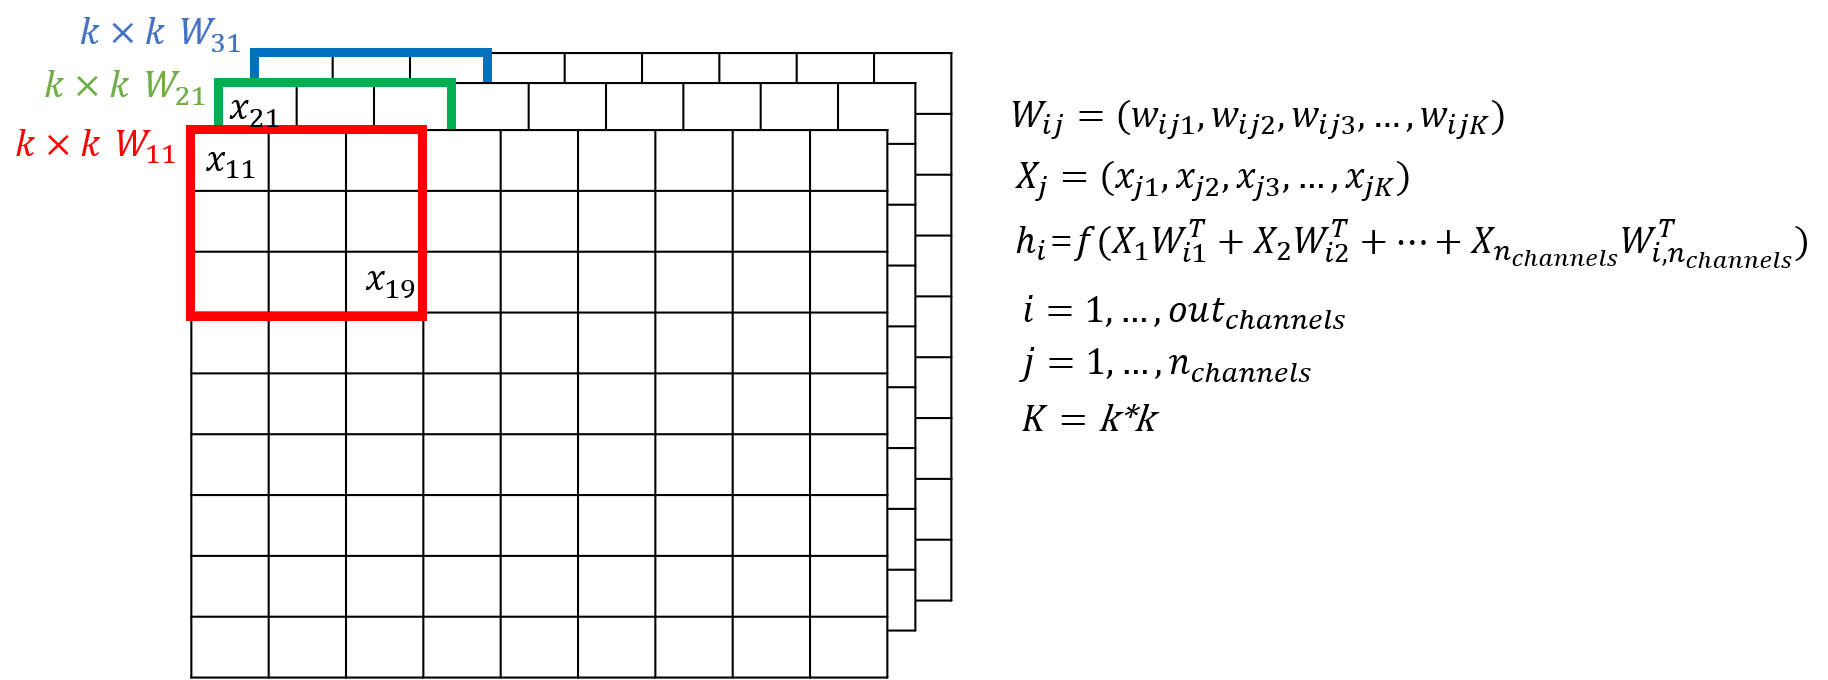

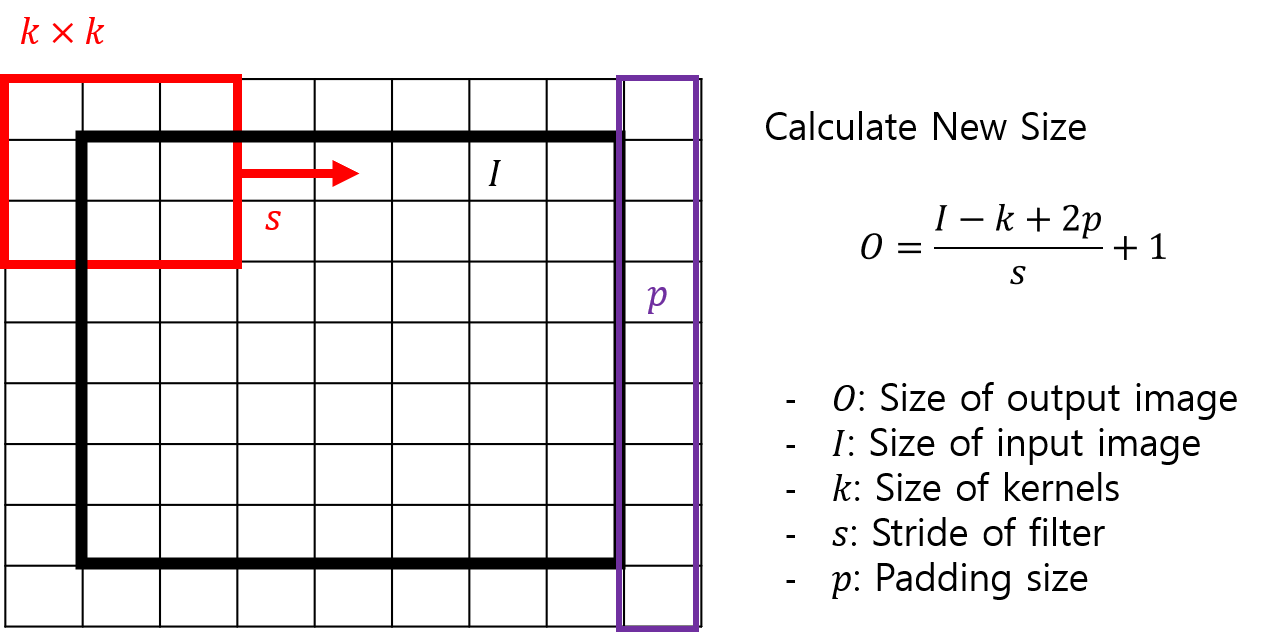

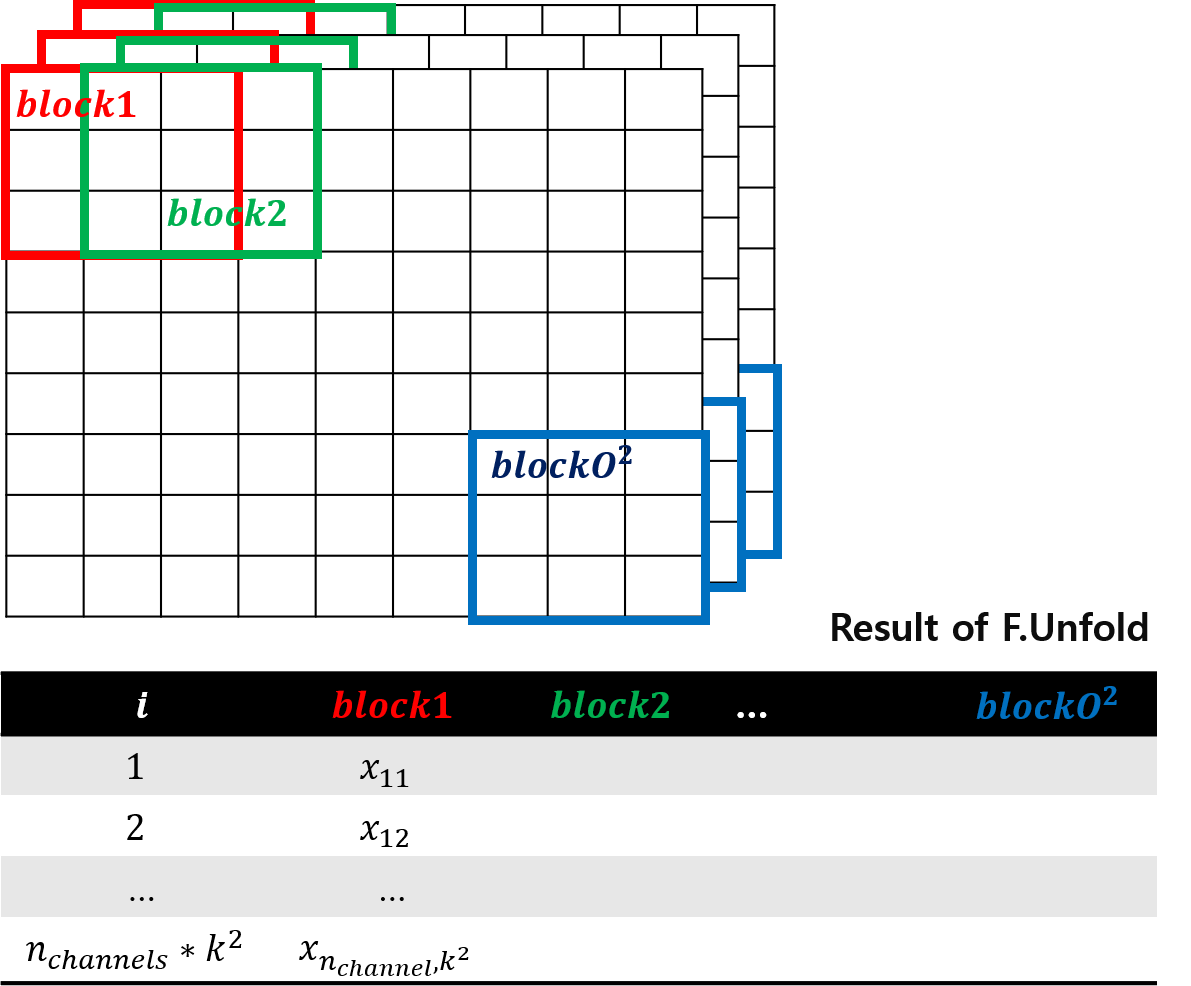

In [40]:
from sys import stdout

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import math

##############

device = torch.device("cuda:0")
epochs = 10
batch_size = 32

##############

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

##############

class MyConv2d(nn.Module):
    def __init__(self, n_channels, out_channels, kernel_size, dilation=1, padding=0, stride=1):
        super(MyConv2d, self).__init__()

        self.kernel_size = kernel_size
        self.kernal_size_number = kernel_size * kernel_size
        self.out_channels = out_channels
        self.dilation = (dilation, dilation)
        self.padding = (padding, padding, padding, padding)
        self.stride = (stride, stride)
        self.n_channels = n_channels
        self.weights = nn.Parameter(torch.Tensor(self.out_channels, self.n_channels, self.kernel_size, self.kernel_size))

    def forward(self, x):
        # xm = F.pad(x,self.padding,mode='constant',value=0)
        # xm = m(x) # padding이 됨
        width = self.calculateNewWidth(x)
        height = self.calculateNewHeight(x)
        
        windows = F.unfold(
            x, kernel_size=self.kernel_size, padding=self.padding[0], dilation=self.dilation, stride=self.stride
        )

        windows = windows.transpose(1, 2).matmul(self.weights.view(self.weights.size(0), -1).t()).transpose(1,2)
        result = windows.view(-1, self.out_channels, width, height)

        return result  

    def calculateNewWidth(self, x):
        return (
            (x.shape[2] + 2 * self.padding[0] - self.dilation[0] * (self.kernel_size - 1) - 1)
            // self.stride[0]
        ) + 1

    def calculateNewHeight(self, x):
        return (
            (x.shape[3] + 2 * self.padding[1] - self.dilation[1] * (self.kernel_size - 1) - 1)
            // self.stride[1]
        ) + 1

    def get_weights(self):
        kernal_size = int(math.sqrt(self.kernal_size_number))
        return nn.Parameter(self.weights.view(self.out_channels, self.n_channels, kernal_size, kernal_size))

##############

print("-------")
conv = MyConv2d(3, 1, 3).cuda()
x = torch.randn(1, 3, 24, 24).cuda()
out = conv(x)
out.mean().backward()
print(conv.weights.grad)
print("-------")

##############

class TestModel(nn.Module):
    def __init__(self):
        super(TestModel, self).__init__()
        
        self.conv1 = MyConv2d(3, 64, 3)
        self.conv2 = torch.nn.Conv2d(3, 64, 3, bias=False)
        self.conv2.weight = self.conv1.get_weights()  
        
    def forward(self, x):
        y1 = self.conv1(x)
        y2 = self.conv2(x)
        
        return [y1,y2]
    
model = TestModel().to(device)

x, _ = [ x[0:32] for x in iter(trainloader).next() ]
x = x.to(device)

result = model(x)
print(torch.sum(result[1]-result[0]))
print("-------")
    
##############

class CnnModel(nn.Module):
    def __init__(self):
        super(CnnModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, bias=False)
        self.conv2 = nn.Conv2d(64, 32, 3, bias=False)
        
        # self.conv1 = MyConv2d(3, 64, 3)
        # self.conv2 = MyConv2d(64, 32, 3)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(32 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 32 * 6 * 6)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
##############    

model = CnnModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model.train()

for epoch in range(epochs):
    train_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader, 0):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        stdout.write("\r{:5d}/{:5d} --- Loss: {:07.5f} | Acc: {:07.4f} \t\t\t({:05d}/{:05d})".format(
                batch_idx,
                len(trainloader),
                train_loss / (batch_idx + 1),
                100.0 * correct / total,
                correct,
                total,
            )
        )
        stdout.flush()
    stdout.write("\n")

Files already downloaded and verified
Files already downloaded and verified
-------
tensor([[[[-0.0293, -0.0115,  0.0203],
          [-0.0719, -0.0535, -0.0222],
          [-0.0802, -0.0626, -0.0300]],

         [[ 0.0417,  0.0516,  0.0682],
          [ 0.0266,  0.0371,  0.0612],
          [ 0.0176,  0.0324,  0.0548]],

         [[ 0.0827,  0.0645,  0.0458],
          [ 0.0562,  0.0390,  0.0200],
          [ 0.0171,  0.0061, -0.0200]]]], device='cuda:0')
-------
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
-------
 1562/ 1563 --- Loss: 2.12512 | Acc: 22.5400 			(11270/50000)
 1562/ 1563 --- Loss: 1.68796 | Acc: 38.7720 			(19386/50000)
 1562/ 1563 --- Loss: 1.49030 | Acc: 46.3460 			(23173/50000)
 1562/ 1563 --- Loss: 1.36842 | Acc: 50.9440 			(25472/50000)
 1562/ 1563 --- Loss: 1.25818 | Acc: 55.0680 			(27534/50000)
 1562/ 1563 --- Loss: 1.15956 | Acc: 58.8780 			(29439/50000)
 1562/ 1563 --- Loss: 1.07682 | Acc: 62.1500 			(31075/50000)
 1562/ 1563 --- Loss: 1.01451 | Acc: 64